##                                                     MODEL 1: ALL LAYERS FROZEN




**1. Importing necessary libraries**

In [ ]:
!pip install pydicom

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import pydicom
import os
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses, optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from keras import backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import make_scorer, accuracy_score
from tensorflow.keras.applications import DenseNet121, MobileNetV2, ResNet152V2, Xception

In [ ]:
# mounting the google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2. Extracting the files from stage_2_dataset.zip file**

In [ ]:
path = "/content/drive/MyDrive/stage_2_dataset.zip"

In [ ]:
from zipfile import ZipFile
with ZipFile(path,'r') as zip:
  zip.extractall()

In [ ]:
# extract images from train folder

from zipfile import ZipFile
import os

# Path to the zip file
train_images_path = '/content/drive/MyDrive/stage_2_train_images.zip'

# Directory where you want to create the folder and extract the images
extraction_folder = '/content/stage_2_train_images'

# Create the extraction folder if it doesn't exist
os.makedirs(extraction_folder, exist_ok=True)

# Open the zip file
with ZipFile(train_images_path, 'r') as zip_ref:
    # Extract all images to the extraction folder
    zip_ref.extractall(extraction_folder)

print("Extraction complete.")


Extraction complete.


In [ ]:
# read the csv file into dataframe

class_info_df = pd.read_csv('/content/Copy of stage_2_detailed_class_info.csv')

In [ ]:
class_info_df.shape

(30227, 2)

**3. Removing duplicate entries from the dataframe**

In [ ]:
df = class_info_df.copy()

In [ ]:
df.drop_duplicates(inplace = True)

In [ ]:
df.duplicated().sum()

0

In [ ]:
# create a new column with complete paths to images in train folder

import pandas as pd
import os

# Path to the directory containing DICOM images
image_folder = '/content/stage_2_train_images'


# Convert 'patientId' column to string explicitly
df['patientId'] = df['patientId'].astype(str)

# Create a new column 'image_path' by concatenating the folder path and 'patientId'
df['image_path'] = image_folder + os.path.sep + df['patientId'] + '.dcm'

# Save the updated DataFrame back to the CSV file
#df.to_csv(csv_file, index=False)

In [ ]:
df.head()

,patientId,class,image_path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,/content/stage_2_train_images/0004cfab-14fd-4e...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,/content/stage_2_train_images/00313ee0-9eaa-42...
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,/content/stage_2_train_images/00322d4d-1c29-49...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,/content/stage_2_train_images/003d8fa0-6bf1-40...
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,/content/stage_2_train_images/00436515-870c-4b...


**4. Selecting only 2000 rows out of the whole dataframe**

In [ ]:
# select 2000 images with equal distribution of classes

import pandas as pd
import random

# Create three separate DataFrames based on 'class' values
df_normal = df[df['class'] == 'Normal']
df_lung_opacity = df[df['class'] == 'Lung Opacity']
df_not_normal = df[df['class'] == 'No Lung Opacity / Not Normal']


# Define the number of entries you want to select for each class
num_lung_opacity = 1000
num_normal = 500
num_not_normal = 500

# Randomly select entries for each class
selected_normal = df_normal.sample(n=num_normal, random_state=42)
selected_lung_opacity = df_lung_opacity.sample(n=num_lung_opacity, random_state=42)
selected_not_normal = df_not_normal.sample(n=num_not_normal, random_state=42)

# Concatenate the selected DataFrames to create the final DataFrame
final_df = pd.concat([selected_normal, selected_lung_opacity, selected_not_normal])

# Shuffle the final DataFrame to randomize the order
final_df = final_df.sample(frac=1, random_state=42)

# Extract 'image_path' entries corresponding to the selected rows
selected_image_paths = final_df['image_path'].tolist()

# Create a new DataFrame that includes both selected rows and 'image_path' entries
filtered_df = df[df['image_path'].isin(selected_image_paths)]
filtered_df = filtered_df.reset_index(drop=True)

In [ ]:
filtered_df.head()

,patientId,class,image_path
0,0174c4bb-28f5-41e3-a13f-a396badc18bd,Lung Opacity,/content/stage_2_train_images/0174c4bb-28f5-41...
1,01be392f-a46d-4aef-a57e-9cd1a80dd47e,Lung Opacity,/content/stage_2_train_images/01be392f-a46d-4a...
2,01c09fb1-a917-46ee-8d94-44f844a4eb85,No Lung Opacity / Not Normal,/content/stage_2_train_images/01c09fb1-a917-46...
3,01cad8d0-45cd-4603-b099-94055d322310,Lung Opacity,/content/stage_2_train_images/01cad8d0-45cd-46...
4,01d4fa0f-97a0-4522-b0d8-134400db2a3e,Lung Opacity,/content/stage_2_train_images/01d4fa0f-97a0-45...


In [ ]:
filtered_df['class'].value_counts()

Lung Opacity                    1000
No Lung Opacity / Not Normal     500
Normal                           500
Name: class, dtype: int64

**5. Creating a new column 'label' containing 0 for 'Normal and No Lung Opacity/Not Normal' classes and 1 for 'Lung Opacity'.**

In [ ]:
filtered_df['label'] = filtered_df['class'].apply(lambda x: 1 if x == 'Lung Opacity' else 0)

filtered_df.head(10)

,patientId,class,image_path,label
0,0174c4bb-28f5-41e3-a13f-a396badc18bd,Lung Opacity,/content/stage_2_train_images/0174c4bb-28f5-41...,1
1,01be392f-a46d-4aef-a57e-9cd1a80dd47e,Lung Opacity,/content/stage_2_train_images/01be392f-a46d-4a...,1
2,01c09fb1-a917-46ee-8d94-44f844a4eb85,No Lung Opacity / Not Normal,/content/stage_2_train_images/01c09fb1-a917-46...,0
3,01cad8d0-45cd-4603-b099-94055d322310,Lung Opacity,/content/stage_2_train_images/01cad8d0-45cd-46...,1
4,01d4fa0f-97a0-4522-b0d8-134400db2a3e,Lung Opacity,/content/stage_2_train_images/01d4fa0f-97a0-45...,1
5,01e16ddb-682d-4901-b56d-8686c4f9f976,No Lung Opacity / Not Normal,/content/stage_2_train_images/01e16ddb-682d-49...,0
6,01e4fd43-4f2c-421f-bd68-c756dceb5742,Normal,/content/stage_2_train_images/01e4fd43-4f2c-42...,0
7,01f4cd36-caa1-480f-9d8c-92e80cf7b197,Normal,/content/stage_2_train_images/01f4cd36-caa1-48...,0
8,020380f8-5c5a-4ded-bdf3-9ce3036945b4,Lung Opacity,/content/stage_2_train_images/020380f8-5c5a-4d...,1
9,0280a39c-4891-4a7b-8073-710c3f5577a3,Normal,/content/stage_2_train_images/0280a39c-4891-4a...,0


In [ ]:
filtered_df['label'].value_counts()

1    1000
0    1000
Name: label, dtype: int64

In [ ]:
filtered_df.shape

(2000, 4)

In [ ]:
filtered_df.head()

,patientId,class,image_path,label
0,0174c4bb-28f5-41e3-a13f-a396badc18bd,Lung Opacity,/content/stage_2_train_images/0174c4bb-28f5-41...,1
1,01be392f-a46d-4aef-a57e-9cd1a80dd47e,Lung Opacity,/content/stage_2_train_images/01be392f-a46d-4a...,1
2,01c09fb1-a917-46ee-8d94-44f844a4eb85,No Lung Opacity / Not Normal,/content/stage_2_train_images/01c09fb1-a917-46...,0
3,01cad8d0-45cd-4603-b099-94055d322310,Lung Opacity,/content/stage_2_train_images/01cad8d0-45cd-46...,1
4,01d4fa0f-97a0-4522-b0d8-134400db2a3e,Lung Opacity,/content/stage_2_train_images/01d4fa0f-97a0-45...,1


In [ ]:
filtered_df['class'].value_counts()

Lung Opacity                    1000
No Lung Opacity / Not Normal     500
Normal                           500
Name: class, dtype: int64

In [ ]:
filtered_df['label'] = filtered_df['label'].astype(str)

**6. Using only two columns, 'image_path' and 'label' for training,validation and testing our model.  
Storing in 'x', the images after reading them from 'image_path' column, downsizing them from 1024 pixels to 224 pixels, and converting them to 3 channel(RGB) images as the pre-trained models expect the input image in 3 channel format.  
Storing in 'y' the labels for each image after converting them in array format.**

In [ ]:
import pydicom
import cv2
def read_and_resize_images(df):
    resized_images = []
    boxes = []
    for i in range(len(df)):
        image_path = df['image_path'][i]
        target = df['label'][i]
        dicom_data = pydicom.read_file(image_path)
        img = dicom_data.pixel_array

        #Resize image to 224x224 because we are going to use DenseNet121 that takes in rgb images(3 channels)
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        resized_images.append(img)
        boxes.append(np.array(target, dtype=np.float32))
    return np.array(resized_images), np.array(boxes)

In [ ]:
x, y = read_and_resize_images(filtered_df)

7. Splitting the dataset into train, validation and test sets

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size = 0.3,random_state = 42)

In [ ]:
print(x_train.shape, y_train.shape)
print(x_temp.shape, y_temp.shape)


(1400, 224, 224, 3) (1400,)
(600, 224, 224, 3) (600,)


In [ ]:
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size = 0.20,random_state = 42)

In [ ]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(1400, 224, 224, 3) (1400,)
(120, 224, 224, 3) (120,)
(480, 224, 224, 3) (480,)


**8. Normalising the image pixels by dividing them by the maximum pixel value 255.**

In [ ]:
def preprocess_and_reshape(images):
    images = images/ 255.0
    return images
x_train = preprocess_and_reshape(x_train)
x_val = preprocess_and_reshape(x_val)
x_test = preprocess_and_reshape(x_test)

**9. Setting image augmentation parameters using ImageDataGenerator for train images only**



In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# create image augmentation parameters for train images only

train_datagen = ImageDataGenerator(
      rotation_range=5,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

**10. Extracting the chexnet weights by extracting them from the zip file**

In [ ]:
# extract chexnet weights

from zipfile import ZipFile
import os

# Path to the zip file
chexnet_weight_path = "/content/drive/MyDrive/chexnet_weights.zip"

# Directory where you want to create the folder and extract the images
extraction_folder = '/content/chexnet_weights'

# Create the extraction folder if it doesn't exist
os.makedirs(extraction_folder, exist_ok=True)

# Open the zip file
with ZipFile(chexnet_weight_path, 'r') as zip_ref:
    # Extract all images to the extraction folder
    zip_ref.extractall(extraction_folder)

print("Extraction complete.")

Extraction complete.


**11. Building the base model using DenseNet121**

In [ ]:
# Load the pre-trained CheXNet model weights
chexnet_weights_path = '/content/chexnet_weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'

# Define the CheXNet model architecture
base_model = DenseNet121(include_top=False, weights=None, input_shape=(224, 224, 3))

# Add a custom classification layer for binary classification
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu',kernel_regularizer=l2(0.0002))(x)
x= Dropout(0.30)(x)
x = Dense(256, activation='relu',kernel_regularizer=l2(0.0002))(x)
x= Dropout(0.30)(x)
output_layer = Dense(1, activation='sigmoid')(x)

# Create the new model
model = Model(inputs=base_model.input, outputs=output_layer)

# Load the CheXNet weights into the model, except for the custom output layer
model.load_weights(chexnet_weights_path, by_name=True, skip_mismatch=True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [ ]:
# compile the model

model.compile(optimizer=Adam(learning_rate = 0.00001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Define a ModelCheckpoint callback to save the best weights
checkpoint = ModelCheckpoint('best_weights.h5', monitor='val_loss', save_best_only=True, verbose=1)
# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)

In [ ]:
r = model.fit(x_train, y_train, batch_size = 64, epochs =50,  validation_data =(x_val, y_val), callbacks=[checkpoint,early_stopping,reduce_lr])

Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 0.8894 - accuracy: 0.5393
Epoch 1: val_loss improved from inf to 0.86660, saving model to best_weights.h5
22/22 [==============================] - 131s 2s/step - loss: 0.8894 - accuracy: 0.5393 - val_loss: 0.8666 - val_accuracy: 0.7354 - lr: 1.0000e-05
Epoch 2/50
22/22 [==============================] - ETA: 0s - loss: 0.8605 - accuracy: 0.6193
Epoch 2: val_loss improved from 0.86660 to 0.85144, saving model to best_weights.h5
22/22 [==============================] - 19s 874ms/step - loss: 0.8605 - accuracy: 0.6193 - val_loss: 0.8514 - val_accuracy: 0.7125 - lr: 1.0000e-05
Epoch 3/50
22/22 [==============================] - ETA: 0s - loss: 0.8339 - accuracy: 0.6529
Epoch 3: val_loss improved from 0.85144 to 0.83095, saving model to best_weights.h5
22/22 [==============================] - 20s 898ms/step - loss: 0.8339 - accuracy: 0.6529 - val_loss: 0.8309 - val_accuracy: 0.7292 - lr: 1.0000e-05
Epoch 4/50
22/22 [=======

In [ ]:
'''
# Model training on augmented train images
batch_size = 32
r = model.fit(
    x=train_datagen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train) // batch_size,
    epochs=70, callbacks=[checkpoint,early_stopping,reduce_lr])
'''

'\n# Model training\nbatch_size = 32\nr = model.fit(\n    x=train_datagen.flow(x_train, y_train, batch_size=batch_size),\n    validation_data=(x_val, y_val),\n    steps_per_epoch=len(x_train) // batch_size,\n    epochs=70, callbacks=[checkpoint,early_stopping,reduce_lr])\n'

Text(0.5, 1.0, 'Accuracy Evolution')

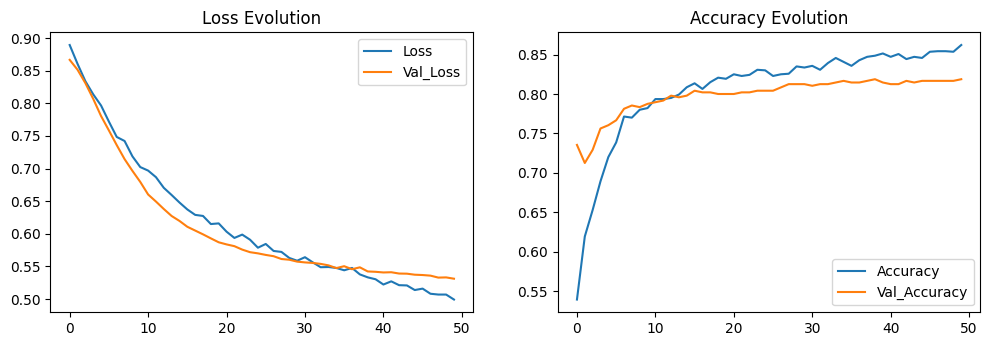

In [ ]:
# plot the accuracy and loss curves

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')


In [ ]:
# Print training loss and accuracy for best weights
best_train_loss = min(r.history['loss'])  # Minimum training loss
best_train_accuracy = max(r.history['accuracy'])  # Maximum training accuracy
print(f'Best Training Loss: {best_train_loss:.4f}')
print(f'Best Training Accuracy: {best_train_accuracy:.2%}')

Best Training Loss: 0.4991
Best Training Accuracy: 86.21%


In [ ]:
# Load the best weights
model.load_weights('best_weights.h5')

# Evaluate the model with the best weights
val_loss, val_accuracy = model.evaluate(x_val, y_val)

print(f'Best Validation Loss: {val_loss:.4f}')
print(f'Best Validation Accuracy: {val_accuracy:.2%}')

15/15 [==============================] - 2s 99ms/step - loss: 0.5311 - accuracy: 0.8188
Best Validation Loss: 0.5311
Best Validation Accuracy: 81.88%


In [ ]:
from tensorflow.keras.models import load_model, save_model

# Save the trained model to a file
model.save('chexnet.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('chexnet.h5')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict on the test set
y_pred_ = model.predict(x_val)

15/15 [==============================] - 4s 93ms/step


**12. Selecting the threshold value for binary classification: 0 for 'No Lung Opacity or 1 for 'Lung Opacity', from range 0.1 to 0.9 on the basis of the best F1-score obtained using the validation data.**

In [ ]:
# find out the best threshold value

import numpy as np
from sklearn.metrics import f1_score

thresholds = np.linspace(0.1, 0.9, 9)

best_f1 = 0.0  # Initialize the best F1-score
best_threshold = 0.5  # Initialize the best threshold

# Iterate through the thresholds and calculate F1-score for each
for threshold in thresholds:
    # Convert predicted probabilities to binary labels using the current threshold
    y_pred_binary = (y_pred_ > threshold).astype(int)

    # Calculate F1-score for the current threshold
    current_f1 = f1_score(y_val, y_pred_binary)

    # Check if the current threshold gives a better F1-score
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = threshold

print(f'Best Threshold: {best_threshold:.2f}')
print(f'Best F1 Score: {best_f1:.2f}')


Best Threshold: 0.60
Best F1 Score: 0.85


**13. Predicting the model on test dataset**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict on the test set
y_pred = model.predict(x_test)


4/4 [==============================] - 6s 994ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert predicted probabilities to binary labels (assuming binary classification)
y_pred_binary = (y_pred > best_threshold).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)

# Calculate precision
precision = precision_score(y_test, y_pred_binary)

# Calculate recall
recall = recall_score(y_test, y_pred_binary)

# Calculate F1-score
f1 = f1_score(y_test, y_pred_binary)

print(f'Test Accuracy: {accuracy:.2%}')
print(f'Test Precision: {precision:.2f}')
print(f'Test Recall: {recall:.2f}')
print(f'Test F1 Score: {f1:.2f}')

Test Accuracy: 80.83%
Test Precision: 0.79
Test Recall: 0.80
Test F1 Score: 0.80


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Generate a classification report
class_report = classification_report(y_test, y_pred_binary , target_names=['No Lung Opacity','Lung Opacity'])

# Print the classification report
print("Classification Report:\n", class_report)

Classification Report:
                  precision    recall  f1-score   support

No Lung Opacity       0.83      0.81      0.82        64
   Lung Opacity       0.79      0.80      0.80        56

       accuracy                           0.81       120
      macro avg       0.81      0.81      0.81       120
   weighted avg       0.81      0.81      0.81       120



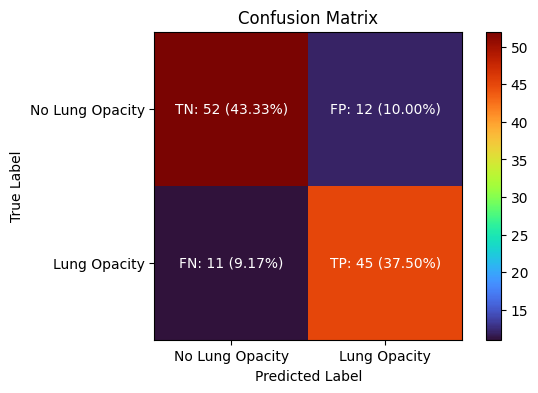

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Calculate TP, FP, TN, FN
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]

# Calculate percentages
total_samples = len(y_test)
percent_TP = (TP / total_samples) * 100
percent_FP = (FP / total_samples) * 100
percent_TN = (TN / total_samples) * 100
percent_FN = (FN / total_samples) * 100

# Create a custom function for annotating the confusion matrix
def annotate_confusion_matrix(conf_matrix):
    plt.imshow(conf_matrix, interpolation='nearest',cmap = 'turbo')
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(['No Lung Opacity', 'Lung Opacity']))
    plt.xticks(tick_marks, ['No Lung Opacity', 'Lung Opacity'])
    plt.yticks(tick_marks, ['No Lung Opacity', 'Lung Opacity'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Annotate TP, FP, TN, FN, and their percentages
    for i in range(2):
        for j in range(2):
            plt.text(j, i, f'TP: {conf_matrix[1, 1]} ({percent_TP:.2f}%)' if i == 1 and j == 1
                             else f'FP: {conf_matrix[0, 1]} ({percent_FP:.2f}%)' if i == 0 and j == 1
                             else f'TN: {conf_matrix[0, 0]} ({percent_TN:.2f}%)' if i == 0 and j == 0
                             else f'FN: {conf_matrix[1, 0]} ({percent_FN:.2f}%)' if i == 1 and j == 0
                             else '',
                     horizontalalignment='center',
                     verticalalignment='center',
                     color='white', fontsize=10)

# Plot the annotated confusion matrix
plt.figure(figsize=(6, 4))
annotate_confusion_matrix(conf_matrix)
plt.show()


The two classes in this confusion matrix are "No Lung Opacity" and "Lung Opacity." The matrix shows that the model correctly predicted 52 instances of "No Lung Opacity" and 45 instances of "Lung Opacity." However, the model also incorrectly predicted 11 instances of "Lung Opacity" as "No Lung Opacity" and 12 instances of "No Lung Opacity" as "Lung Opacity."

**14. Creating AUC-ROC curve using predicted probabilties on the test set.**

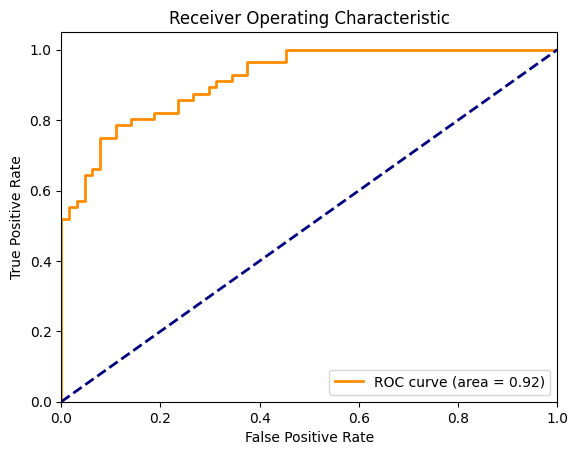

In [ ]:
# Generate ROC curve and calculate AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

**15. Creating AUC-ROC curve after converting the predicted probabilities on test data to binary labels.**

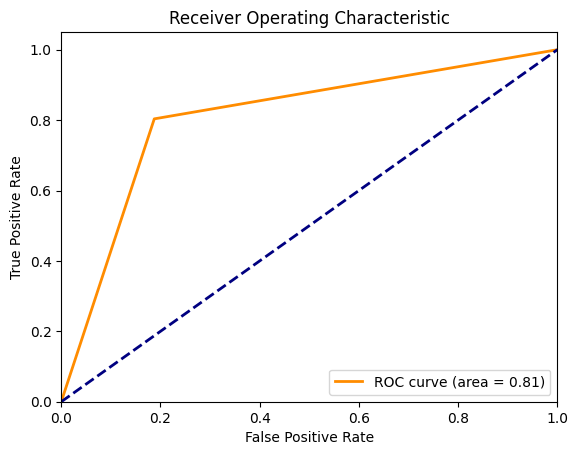

In [ ]:
# Generate ROC curve and calculate AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_binary)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()